### import just do it! :p

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

### here is a very important step to define how much batch size and how many epochs are to be set. you can paly around with these number and find the best suitable one. PS: use these 

In [3]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

### make sure you change the path to your path where datasets are saved

In [4]:
DIRECTORY = r"C:\Users\irfan\OneDrive\Desktop\my projects\Face-Mask-Detection-master\dataset"
CATEGORIES = ["with_mask", "without_mask"]

In [5]:
# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

data = []
labels = []


[INFO] loading images...


In [6]:
for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	data.append(image)
    	labels.append(category)

C:\Users\irfan\anaconda3\lib\site-packages\PIL\Image.py:962: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [7]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)


In [8]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [9]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

9412608/9406464 [==============================] - 1s 0us/step


In [10]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


In [11]:
model = Model(inputs=baseModel.input, outputs=headModel)


In [12]:
for layer in baseModel.layers:
	layer.trainable = False

In [13]:
# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


## THE EXECUTION IS GONNA TAKE LONG SO BE PATIENT!

In [14]:
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
95/95 [==============================] - 152s 2s/step - loss: 0.3868 - accuracy: 0.8243 - val_loss: 0.0948 - val_accuracy: 0.9831
Epoch 2/20
95/95 [==============================] - 150s 2s/step - loss: 0.1151 - accuracy: 0.9598 - val_loss: 0.0572 - val_accuracy: 0.9844
Epoch 3/20
95/95 [==============================] - 152s 2s/step - loss: 0.0801 - accuracy: 0.9746 - val_loss: 0.0502 - val_accuracy: 0.9870
Epoch 4/20
95/95 [==============================] - 152s 2s/step - loss: 0.0711 - accuracy: 0.9756 - val_loss: 0.0384 - val_accuracy: 0.9883
Epoch 5/20
95/95 [==============================] - 152s 2s/step - loss: 0.0573 - accuracy: 0.9809 - val_loss: 0.0388 - val_accuracy: 0.9883
Epoch 6/20
95/95 [==============================] - 150s 2s/step - loss: 0.0530 - accuracy: 0.9812 - val_loss: 0.0352 - val_accuracy: 0.9883
Epoch 7/20
95/95 [==============================] - 151s 2s/step - loss: 0.0490 - accuracy: 0.9822 - val_loss: 0.0327 - val_accura

In [15]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)


[INFO] evaluating network...


In [16]:
#for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [17]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.99      1.00      0.99       383
without_mask       1.00      0.99      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



In [18]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("mask_detector.model", save_format="h5")


[INFO] saving mask detector model...


### Here is your plot of how accurate your model is trained

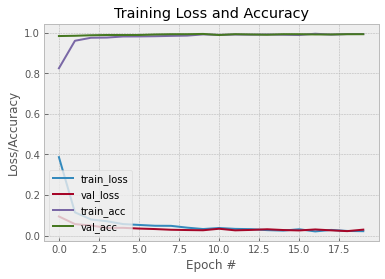

In [20]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("bmh")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")